# Introduction

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json

## Motivation

Our project was inspired by Tyson Ni's great work in The Daily Bruin in investigating public data, experimenting with technology and apply quantitative insights to real life. Some of his work is available on the Stack, a data journalism and newsroom tech blog which can be found here: https://stack.dailybruin.com/.

In particular, we were very interested in looking at Tyson's analysis of General Education (GE) classes and wanted to see if we could take it a step further and create a model to predict easy 'GEs'. Tyson's original work can be found here: https://stack.dailybruin.com/2016/02/24/grades-ge/

Every UCLA student will understand how inconvenient GE classes are. For many, they represent subjects that the student isn't good at and can be serious GPA-killers. In any case, every student is looking to choose the easiest of GEs, whether they are trying to take the easy way out or simply trying to reduce their overall workload (college is tough, let's admit it). In this case, 'easiest' can be defined as 'most likely to get As'.

Tyson's work includes analysis on several key characteristics:
- Percentage of As for each course
- Frequencies of each course
- Variance in grades for each course

One characteristic that was missing is the professor teaching the course. We felt that professors play a very huge role in determining the ultimate distribution of the grades and should be taken into consideration. We also want to extend Tyson's work by seeing if we can build a model to predict the number of As given certain course features namely:
- Course Name
- Department Name
- GE Foundation
- Professor Name
- Class Size

Notice how the above features are what a regular student would have easy access to when choosing classes on myUCLA (without having to scroll through Bruinwalk and clicking through reviews).

Thus, we contacted Daily Bruin and retrieved two datasets from them:

- **data.csv**: Contains grade information on classes taught in UCLA since 2006 (but effectively since 2013 due to missing data)
- **ge.csv**: Contains GE information on which classes are General Education (GE) classes

We will use these two datasets in our analysis and modeling.

## Data Collection

The Daily Bruin retrieved its grades data via public records requests to the UCLA Registrar. The dataset that we obtained from The Daily Bruin is the same as that which is being used to display grade distribution data on https://www.bruinwalk.com/.

Bruinwalk is a website maintained by the Daily Bruin to give UCLA students an edge in selecting and picking classes that are most optimal for them. Many students, ourselves included, use the data to pick out 'easy' courses that can help as GPA boosters. As such, we will use this same data to see if we can find meaningful patterns in the grades distributions.

Here are just a few limitations of our dataset that we will like to disclose upfront:
- Some courses can count for more than one General Education (GE) category, however our data does not have information on this and maps only one GE category to a relevant GE course
- Some courses are taught by multiple professors, but our data only reflects one professor per course
- We do not have data on course units, and thus, GPA aggregation formulas may not be 100% accurate
- Some courses are renamed and may not be considered the 'same course' in our analysis due to differences in these names

## Features of Grades Dataset data
Each observation in **data** is a class taught at UCLA and each column is a feature of the class. There are a total of 31568 classes and 56 class columns in this dataset.

In [3]:
data = pd.read_csv("data.csv", index_col = 0)
data.shape

(31568, 57)

First we take a look at the columns of the dataset.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31568 entries, 0 to 31567
Data columns (total 57 columns):
department                     31568 non-null int64
grade_A                        31568 non-null int64
grade_Am                       31568 non-null int64
grade_Ap                       31568 non-null int64
grade_B                        31568 non-null int64
grade_Bm                       31568 non-null int64
grade_Bp                       31568 non-null int64
grade_C                        31568 non-null int64
grade_Cm                       31568 non-null int64
grade_Cp                       31568 non-null int64
grade_D                        31568 non-null int64
grade_Dm                       31568 non-null int64
grade_Dp                       31568 non-null int64
grade_F                        31568 non-null int64
grade_L                        31568 non-null int64
grade_R                        31568 non-null int64
grade_deferred_report          31568 non-null int64
grade_i

### Basic Features

The 2 most basic features that each course has is:
- '**prof_name**': The name of the professor teaching the class (5141 unique)
- '**course_name**': The name of the class as it appears when students enroll in the class on my.ucla (5225 unique)

In [5]:
data.loc[0::1000,['prof_name','course_name']].head()

,prof_name,course_name
0,kuo-nan-liou,A&O SCI 1
1000,rene-a-ong,PHYSICS 89
2000,m-f-marra,JAPAN 110
3000,karen-j-cunningham,ENGL 190H
4000,sarah-h-tolbert,CHEM 20B


In [6]:
print(data.prof_name.nunique(), data.course_name.nunique())

5141 5225


### Time Features

There are 2 features related to time:
- '**term_year**': Year in which the course was taught (range from 2006 - 2017)
- '**term_quarter**': Quarter in which the course was taught - Fall, Winter, Spring and Summer (FA, WI, SP, SU)

We are missing full academic year data for 2006-2012, so we will use only data from 2012 Fall onwards.

In [7]:
data.term_year.astype(str).str.cat(data.term_quarter).unique()

array(['2006SP', '2006FA', '2009FA', '2010WI', '2010SP', '2012FA',
       '2013SU', '2013FA', '2013SP', '2013WI', '2014SU', '2014FA',
       '2014SP', '2014WI', '2015SU', '2015FA', '2015SP', '2015WI',
       '2016SP', '2016SU', '2016WI', '2016FA', '2017FA', '2017SP',
       '2017WI'], dtype=object)

### Department Features

There are 3 categorical variables related to department: 
- '**department**': Department ID number (166 unique)
- '**dept_name**': Department full name (162 unique)
- '**dept_short_name**': Department abbreviated name, that is also found in course names (166 unique)

The 'department' column is just the department ID, which is not very useful in our case because we want to know exactly what the departments are.

In [8]:
data.loc[0::1000,['department','dept_name','dept_short_name']].head()

,department,dept_name,dept_short_name
0,30,Atmospheric and Oceanic Sciences,A&O SCI
1000,147,Physics,PHYSICS
2000,103,Japanese,JAPAN
3000,193,English,ENGL
4000,42,Chemistry and Biochemistry,CHEM


In [9]:
print(data.department.nunique(),data.dept_name.nunique(),data.dept_short_name.nunique())

166 162 166


We notice that there are less department names than there are department IDs, so we want to figure out why there is a discrepancy between the two.

In [10]:
data.sort_values('dept_name').dept_name.str.cat(data.sort_values('dept_name').dept_short_name).unique()

array(['Aerospace StudiesAERO ST', 'African American StudiesAF AMER',
       'African LanguagesAF LANG', 'AfrikaansAFRKAAN',
       'Afro-American StudiesAFRO-AM', 'American Indian StudiesAM IND',
       'American Sign LanguageASL', 'Ancient Near EastAN N EA',
       'AnthropologyANTHRO', 'Applied LinguisticsAPPLING', 'ArabicARABIC',
       'ArchaeologyARCHEOL', 'Architecture and Urban DesignARCH&UD',
       'ArmenianARMENIA', 'ArtART', 'Art HistoryART HIS',
       'Arts EducationARTS ED', 'Arts and ArchitectureART&ARC',
       'AsianASIAN', 'Asian American StudiesASIA AM', 'AstronomyASTR',
       'Atmospheric and Oceanic SciencesA&O SCI', 'BioengineeringBIOENGR',
       'Biological ChemistryBIOL CH', 'BiomathematicsBIOMATH',
       'Biomedical EngineeringBIOMED', 'Biomedical ResearchBMD RES',
       'BiostatisticsBIOSTAT', 'Central and East European StudiesC&EE ST',
       'Chemical EngineeringCH ENGR', 'Chemistry and BiochemistryCHEM',
       'Chicana and Chicano StudiesCHICANO', 'Ch

Upon close inspection, we find that the 4 culprits are all the music-related majors which have had their short names changed:
- Ethnomusicology ('ETHNOMU' to 'ETHNMUS')
- Music ('MUSIC' to 'MUSC')
- Music History ('MUS HST' to 'MSC HST')
- Music Industry ('MUS IND' to 'MSC IND')

Because of this, we will use '**dept_name**' to group classes by department.

### Grade Features

There are a total of 46 features related to grades of a class, these form most of the numeric variables in the dataset.

In [11]:
data.columns.str.contains('grade_').sum()

46

In general, there are 2 main types of grade variables:
- '**grade_*x***': Number of students receiving *x* grade for the class
- '**grade_*x*_pct**': Percentage of students receiving *x* grade for the class

In [12]:
data.columns[data.columns.str.contains('grade_')]

Index(['grade_A', 'grade_Am', 'grade_Ap', 'grade_B', 'grade_Bm', 'grade_Bp',
       'grade_C', 'grade_Cm', 'grade_Cp', 'grade_D', 'grade_Dm', 'grade_Dp',
       'grade_F', 'grade_L', 'grade_R', 'grade_deferred_report',
       'grade_in_progress', 'grade_incomplete', 'grade_no_grade_received',
       'grade_no_pass', 'grade_pass', 'grade_satisfactory',
       'grade_unsatisfactory', 'grade_A_pct', 'grade_Am_pct', 'grade_Ap_pct',
       'grade_B_pct', 'grade_Bm_pct', 'grade_Bp_pct', 'grade_C_pct',
       'grade_Cm_pct', 'grade_Cp_pct', 'grade_D_pct', 'grade_Dm_pct',
       'grade_Dp_pct', 'grade_F_pct', 'grade_L_pct', 'grade_R_pct',
       'grade_deferred_report_pct', 'grade_in_progress_pct',
       'grade_incomplete_pct', 'grade_no_grade_received_pct',
       'grade_no_pass_pct', 'grade_pass_pct', 'grade_satisfactory_pct',
       'grade_unsatisfactory_pct'],
      dtype='object')

At the end of a quarter, each student receives a final grade for the course which measures how well the student has performed for the course.

There are 13 different letter grades:
- **Ap, A, Am**: A+/A/A- grades
- **Bp, B, Bm**: B+/B/B- grades
- **Cp, C, Cm**: C+/C/C- grades
- **Dp, D, Dm**: D+/D/D- grades
- **F**: Fail grade


There are also 4 non-letter grades:
- **pass** and **no_pass**: P/NP grading used for some students taking non-major calsses
- **satisfactory** and **unsatisfactory**: S/US grading used for graduate classes (essentially P/NP for graduate classes)


There are 6 other grades:
- **L**: Letter grade but professor has not reported it yet
- **R**: Non-letter grade but professor has not reported it yet
- **in_progress**: IP grade meaning course is still in progress
- **incomplete**: I grade meaning student did not complete the course
- **deferred_report**: DR grade meaning grades have not been reported
- **no_grade_received**: NG grade meaning grades have not been received, similar to deferred report

This gives us a total of 23 possible grade indicators and multiplying by 2 for number and percentage gives us 46 exactly.

In [13]:
grades = ['F','Dm','D','Dp','Cm','C','Cp','Bm','B','Bp','Am','A','Ap']
gradecols = ['grade_' + s for s in grades]
data.loc[:,gradecols].head()

,grade_F,grade_Dm,grade_D,grade_Dp,grade_Cm,grade_C,grade_Cp,grade_Bm,grade_B,grade_Bp,grade_Am,grade_A,grade_Ap
0,2,2,0,1,4,3,7,5,6,15,8,4,2
1,2,0,4,0,2,24,6,11,49,14,6,45,9
2,3,0,8,6,5,19,8,6,39,19,9,72,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,2,0,8,10,8,9,14,12,0


In [14]:
gradepctcols = ['grade_' + s + '_pct' for s in grades]
data.loc[:,gradepctcols].head()

,grade_F_pct,grade_Dm_pct,grade_D_pct,grade_Dp_pct,grade_Cm_pct,grade_C_pct,grade_Cp_pct,grade_Bm_pct,grade_B_pct,grade_Bp_pct,grade_Am_pct,grade_A_pct,grade_Ap_pct
0,0.029851,0.029851,0.000000,0.014925,0.059701,0.044776,0.104478,0.074627,0.089552,0.223881,0.119403,0.059701,0.029851
1,0.009569,0.000000,0.019139,0.000000,0.009569,0.114833,0.028708,0.052632,0.234450,0.066986,0.028708,0.215311,0.043062
2,0.014423,0.000000,0.038462,0.028846,0.024038,0.091346,0.038462,0.028846,0.187500,0.091346,0.043269,0.346154,0.004808
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.031746,0.000000,0.126984,0.158730,0.126984,0.142857,0.222222,0.190476,0.000000


### Count Features

There are 3 student count features in the dataset:
- '**num_weighted_grades**': Number of letter grades
- '**num_grades**': Number of letter and non-letter grades
- '**total_students**': Total number of students enrolled

In [15]:
data.loc[:,['num_weighted_grades','num_grades','total_students']].head()

,num_weighted_grades,num_grades,total_students
0,59,67,67
1,172,209,209
2,195,210,208
3,0,14,14
4,63,63,63


## Features of GE dataset ge

**ge** has 308 rows and 7 columns, where each row is a unique General Education (GE) course and the columns are features of the course

In [16]:
ge = pd.read_csv("ge.csv")
ge.head()

,Subject,CatalogNo,Name,GE,MedianA,TotClasses,ClassSize
0,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150
1,A&O SCI,2,AIR POLLUTION,Scientific Inquiry-Physical Sciences,0.32,11,169
2,A&O SCI,3,INTR-ATMOS ENVIRMNT,Scientific Inquiry-Physical Sciences,0.30,6,65
3,AF AMER,6,BLACK INTLCTL THGHT,Society and Culture-Historical Analysis,0.57,2,42
4,AFRO-AM,6,BLACK INTLCTL THGHT,Society and Culture-Historical Analysis,0.47,3,55


In [17]:
ge.shape

(308, 7)

Let's take a look at the columns of **ge**

In [18]:
ge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 7 columns):
Subject       308 non-null object
CatalogNo     308 non-null object
Name          308 non-null object
GE            308 non-null object
MedianA       308 non-null float64
TotClasses    308 non-null int64
ClassSize     308 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 16.9+ KB


The variables are as follows:
- '**Subject**': Matches **dept_short_name** of a course in **data**
- '**CatalogNo**': When combined with **Subject**, matches the **course_name** in of a course in **data**
- '**Name**': Department name, but in a different format from **data**
- '**GE**': General Education Category, with the main and sub categories separated by '-'
- '**MedianA**': Median number of As received from the class
- '**TotClasses**': Total number of such classes taught
- '**ClassSize**': Class capacity

We will ignore 'Name', 'MedianA' and 'TotClasses' columns in our analysis of the data because they may not match with our **data** dataset

In [19]:
ge.head()

,Subject,CatalogNo,Name,GE,MedianA,TotClasses,ClassSize
0,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150
1,A&O SCI,2,AIR POLLUTION,Scientific Inquiry-Physical Sciences,0.32,11,169
2,A&O SCI,3,INTR-ATMOS ENVIRMNT,Scientific Inquiry-Physical Sciences,0.30,6,65
3,AF AMER,6,BLACK INTLCTL THGHT,Society and Culture-Historical Analysis,0.57,2,42
4,AFRO-AM,6,BLACK INTLCTL THGHT,Society and Culture-Historical Analysis,0.47,3,55


# Exploratory Data Analysis

## Adding Term

We want to combine the Term and Year columns because they make more sense together

In [20]:
data["term"] = data.apply(lambda x: str(x["term_year"]) + "-" + x["term_quarter"], axis=1)
data.loc[0::1000,['term_year','term_quarter','term']].tail()

,term_year,term_quarter,term
27000,2017,FA,2017-FA
28000,2017,FA,2017-FA
29000,2017,SP,2017-SP
30000,2017,WI,2017-WI
31000,2017,WI,2017-WI


## Adding Division

Maybe it would be a good idea to group departments into larger categories like divisions

The different UCLA divisions can be found here: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=division
- Arts And Architecture (AA)
- Basic Biomedical Sciences (BBS)
- Education And Information Studies (EIS)
- Engineering And Applied Sciences (EAS)
- Humanities (HUM)
- International Institute (II)
- Law (LAW)
- Letters And Science -Interdisciplinary (IDP)
- Life Sciences (LS)
- Management (MGMT)
- Medicine (MED)
- Nursing (NUR)
- Physical Sciences (PS)
- Public Affairs (PA)
- Public Health (PH)
- School of Dentistry (DEN)
- School of Music (MUS)
- School of Theater, Film, And Television (TFT)
- Social Sciences (SS)

We added the School of Dentistry because it showed up in our data, making a total of 19 divisions.

We will first create a new column to store this new category by using a dictionary mapping majors to divisions

In [21]:
majordict = {}

**Arts and Architecture Division (7)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=AA

In [22]:
is_aa = ((data.dept_name.str.contains("Art")) & (data.dept_name != "Art History"))  | (data.dept_name == "Dance") | (data.dept_name.str.contains("Architecture"))
for x in data.dept_name.loc[is_aa].unique():
    majordict[x] = 'AA'
data.dept_name.loc[is_aa].unique()

array(['Architecture and Urban Design', 'Art', 'Arts and Architecture',
       'Design | Media Arts', 'World Arts and Cultures', 'Dance',
       'Arts Education'], dtype=object)

**Basic Biomedical Sciences Division (1)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=BB

In [23]:
majordict['Microbiology, Immunology, and Molecular Genetics'] = 'BBS'

**Education and Information Studies Division (2)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=EI

In [24]:
majordict['Education'] = 'EIS'
majordict['Information Studies'] = 'EIS'

**Engineering and Applied Science Division (9)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=EN

In [25]:
is_eas = (data.dept_name.str.contains("[Ee]ngineer"))| (data.dept_name == "Computer Science")
for x in data.dept_name.loc[is_eas].unique():
    majordict[x] = 'EAS'
data.dept_name.loc[is_eas].unique()

array(['Biomedical Engineering', 'Civil and Environmental Engineering',
       'Chemical Engineering', 'Computer Science',
       'Electrical Engineering', 'Engineering',
       'Materials Science and Engineering',
       'Mechanical and Aerospace Engineering', 'Bioengineering'],
      dtype=object)

Note: Biomedical Engineering has been deprecated since 2011

In [26]:
data.loc[data.dept_name == 'Biomedical Engineering','term_year'].unique()

array([2006, 2009, 2010], dtype=int64)

**Humanities Division (55)**

Added 'Afrikaans'

Added 'Czech' due to https://slavic.ucla.edu/languages/czech/

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=HU

In [27]:
hum = ['American Sign Language', 'Afrikaans',
 'Ancient Near East',
 'Applied Linguistics',
 'Arabic',
 'Armenian',
 'Art History',
 'Asian',
 'Central and East European Studies',
 'Chinese',
 'Classics',
 'Comparative Literature',
 'Digital Humanities',
 'Dutch',
 'English',
 'English as a Second Language',
 'English Composition',
 'Filipino',
 'French',
 'German',
 'Greek',
 'Hebrew',
 'Hindi-Urdu',
 'Hungarian',
 'Indigenous Languages of the Americas',
 'Indo-European Studies',
 'Indonesian',
 'Iranian',
 'Islamic Studies',
 'Italian',
 'Japanese',
 'Jewish Studies',
 'Korean',
 'Latin',
 'Lesbian, Gay, Bisexual, Transgender, and Queer Studies', 'Lesbian, Gay, Bisexual, and Transgender Studies',
 'Linguistics',
 'Middle Eastern Studies',
 'Near Eastern Languages',
 'Philosophy',
 'Polish',
 'Portuguese',
 'Religion, Study of',
 'Romanian',
 'Russian', 'Czech',
 'Scandinavian',
 'Semitics',
 'Serbian/Croatian',
 'Slavic',
 'South Asian',
 'Southeast Asian',
 'Spanish',
 'Swahili',
 'Thai',
 'Turkic Languages',
 'Vietnamese',
 'Yiddish']

In [28]:
for x in hum:
    majordict[x] = 'HUM'
len(hum)

58

**International Institute (7)**

Added 'Islamics' for similarity with 'Islamic Studies'

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=IS

Also on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18S&type=subjarea&division=IS

Addded 'African Languages' based on: http://www.international.ucla.edu/asc/article/80598

Added 'European Studies' based on: http://international.ucla.edu/academics/european

In [29]:
ii = ['Global Studies','International and Area Studies','International Development Studies',
     'Global Health','Islamic Studies','Latin American Studies', 'African Languages', 'European Studies', 'Islamics',
      'Southeast Asian Studies']

It seems like International Migration Studies and African Studies is not found in the data

In [30]:
for x in ii:
    majordict[x] = 'II'

**Law Division (1)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=LW

In [31]:
majordict['Law, Undergraduate'] = 'LAW'

**Interdisciplinary Division (4)**

Added 'Civic Engagement' due to http://www.uei.ucla.edu/academic-programs/civic-engagement/

Added 'Human Complex Systems' due to nature of course

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=GS

In [32]:
idp = ['General Education Clusters','Disability Studies','Environment','Honors Collegium','University Studies',
      'Civic Engagement','Human Complex Systems']
for x in idp:
    majordict[x] = 'IDP'

**Life Sciences Division (9)**

We moved Neuroscience to Medicine Division.

Added 'Physiology' due to similarity with 'Physiological Science'

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=LF

In [33]:
ls = ['Biomedical Research','Computational and Systems Biology','Ecology and Evolutionary Biology',
      'Life Sciences','Molecular, Cell, and Developmental Biology', 'Molecular and Medical Pharmacology',
      'Physiological Science','Psychology','Society and Genetics','Physiology']
for x in ls:
    majordict[x] = 'LS'

**Management Division (1)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=MG

In [34]:
majordict['Management'] = 'MGMT'

**Medicine Division (10)**

Added 'Neurology' due to similarity with 'Neuroscience'

Added 'Medical History' due to similarity with content

Added 'Surgery' due to similarity with Medical courses

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=MN

In [35]:
med = ['Biological Chemistry','Biomathematics','Human Genetics','Medicine','Neurobiology','Neuroscience','Neurology',
       'Psychiatry and Biobehavioral Sciences', 'Medical History','Surgery']

In [36]:
for x in med:
    majordict[x] = "MED"

**School of Nursing Division (1)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=NS

In [37]:
majordict['Nursing'] = 'NUR'

**Physical Science Division (9)**

Dropped 'Planetary' from 'Earth, Planetary and Space Sciences'

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=PS

In [38]:
ps = ['Astronomy', 'Atmospheric and Oceanic Sciences', 'Chemistry and Biochemistry', 'Earth and Space Sciences',
      'Mathematics','Physics','Program in Computing','Science Education','Statistics']
for x in ps:
    majordict[x] = "PS"

**Public Affairs Division (3)**

Dropped 'Public Affairs' because it was not found in data

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=PA

In [39]:
pa = ['Public Policy','Social Welfare','Urban Planning']
for x in pa:
    majordict[x] = "PA"

**Public Health Division (6)**

Added 'Gerontology' and 'Health Services' due to similarity in course content

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=PH

In [40]:
ph = ['Biostatistics','Community Health Sciences','Environmental Health Sciences','Epidemiology','Health Policy and Management',
      'Public Health','Gerontology','Health Services']
for x in ph:
    majordict[x] = "PH"

**School of Dentistry Division (1)**

Based on: https://www.dentistry.ucla.edu/about

In [41]:
majordict['Dentistry'] = 'DEN'

**School of Music Division (4)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=MU

In [42]:
mus = data.dept_name.loc[data.dept_name.str.contains("[Mm]us")].unique()
for x in mus:
    majordict[x] = 'MUS'
mus

array(['Ethnomusicology', 'Music History', 'Music', 'Music Industry'],
      dtype=object)

**School of Theater, Film and Television Division (2)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=TF

In [43]:
majordict['Film and Television'] = 'TFT'
majordict['Theater'] = 'TFT'

**Social Science Division (11)**

Removed 'Conservation of Archaeological and Ethnographic Materials' which was not found in data

Added 'Afro-American Studies' because it is similar to 'African American Studies'

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=SS

Also based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18S&type=subjarea&division=SS

Added 'Communication' and 'Communication Studies' based on http://comm.ucla.edu/requirements

Added 'Women's Studies' to replace 'Gender Studies'

Added 'Military Science' based on http://milsci.ucla.edu/about

Added 'Naval Science' based on http://www.navy.ucla.edu/

Added 'Aerospace Studies' based on http://www.afrotc.ucla.edu/

Added 'Economics' based on https://socialsciences.ucla.edu/departments/

In [44]:
ss = ['African American Studies','Afro-American Studies','American Indian Studies','Anthropology','Asian American Studies',
      'Archaeology','Chicana and Chicano Studies','Geography','History','Political Science','Sociology',
      'Labor and Workplace Studies','Communication', 'Communication Studies',"Women's Studies",'Military Science',
      'Naval Science','Aerospace Studies','Economics']
for x in ss:
    majordict[x] = 'SS'

In [45]:
[x for x in data.dept_name.unique() if x not in majordict.keys()]

[]

In [46]:
data['division'] = [majordict[x] for x in data.dept_name]
data.division.nunique()

19

## Letter Grade Analysis

We can plot grade data for each row as a bar plot as follows

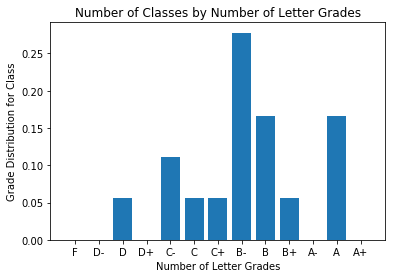

In [47]:
grades2 = ['F','D-','D','D+','C-','C','C+','B-','B','B+','A-','A','A+']
plt.bar(x = grades2, height = data.loc[20,gradepctcols])
plt.ylabel('Grade Distribution for Class')
plt.xlabel('Number of Letter Grades')
plt.title('Number of Classes by Number of Letter Grades')
plt.show()

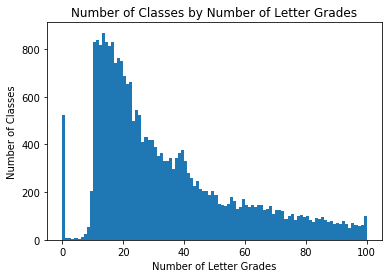

In [48]:
plt.hist(data[gradecols].sum(axis = 1), bins = 100, range = [0,100])
plt.ylabel('Number of Classes')
plt.xlabel('Number of Letter Grades')
plt.title('Number of Classes by Number of Letter Grades')
plt.show()

The histogram above shows the number of classes against number of letter grades received by students. The peak at zero indicates that there are about 500 pass no pass classes that we should deal with.

Although there are also some classes with very low letter grades received (< 10) the number of classes like that is exceptionally small so we can be assured that it will not skew our aggregate data analysis by much.

In [49]:
data.loc[data.loc[:,gradecols].sum(axis = 1) == 0].shape

(524, 59)

We notice that 524 classes are P/NP classes and should be dealt with separately.

Also, note that students who opt to pass / no pass a class should be excluded because they would skew results by perhaps not putting as much effort into a class as they would otherwise.

As such, we should split the data into pass-no-pass classes and letter grade classes.

In [50]:
pnpdata = data.loc[data.loc[:,gradecols].sum(axis = 1) == 0]
lgdata = data.loc[~(data.loc[:,gradecols].sum(axis = 1) == 0)]

Some initial questions to consider:
    - Is grade inflation a thing?
    - Are there professors who are more lenient than others?
    - Are certain departments more competitive than others?
    - Does the weather/seasons affect grade distributions?
    
In order the answer these questions, it might make sense to convert each grade into a GPA to get better numerical results such as the mean, median, quantiles and standard deviations of these distributions.

We will map GPA using the grade point scale found here: https://catalog.registrar.ucla.edu/ucla-catalog18-19-117.html

In [51]:
gradepts = [0,0.7,1.0,1.3,1.7,2.0,2.3,2.7,3.0,3.3,3.7,4.0,4.0]
gradedict = dict(zip(grades2,gradepts))
gradedict

{'F': 0,
 'D-': 0.7,
 'D': 1.0,
 'D+': 1.3,
 'C-': 1.7,
 'C': 2.0,
 'C+': 2.3,
 'B-': 2.7,
 'B': 3.0,
 'B+': 3.3,
 'A-': 3.7,
 'A': 4.0,
 'A+': 4.0}

For each observation, we extract its summary statistics

In [52]:
dist = [[gradepts[i]]*x for i,x in enumerate(data.loc[0,gradecols])]
raw = pd.Series([x for y in dist for x in y])
raw.describe()

count    59.000000
mean      2.816949
std       0.968496
min       0.000000
25%       2.300000
50%       3.000000
75%       3.300000
max       4.000000
dtype: float64

We put the above into a function and apply it over each row

In [53]:
def summstats(row):
    dist = [[gradepts[i]]*x for i,x in enumerate(row)]
    raw = pd.Series([x for y in dist for x in y])
    return(raw.describe())

In [54]:
## We will only apply it on the head for reference
lgdata.loc[:,gradecols].head().apply(summstats, axis = 1)

,count,mean,std,min,25%,50%,75%,max
0,59.0,2.816949,0.968496,0.0,2.3,3.0,3.3,4.0
1,172.0,3.083140,0.845771,0.0,2.7,3.0,4.0,4.0
2,195.0,3.086667,0.978915,0.0,2.5,3.3,4.0,4.0
4,63.0,3.211111,0.635790,1.7,2.7,3.3,3.7,4.0
5,63.0,3.471429,0.781113,0.0,3.3,3.7,4.0,4.0


### Group by Term

Lets dive deeper into the data and see what kind of results we can get based on grouping by **term**

In [55]:
byTermYear = lgdata.groupby(['term_year'])[gradecols].sum().apply(summstats, axis = 1)
byTermYear

,count,mean,std,min,25%,50%,75%,max
term_year,,,,,,,,
2006,156260.0,3.163241,0.840706,0.0,2.7,3.3,4.0,4.0
2009,91144.0,3.188597,0.842559,0.0,2.7,3.3,4.0,4.0
2010,164337.0,3.226533,0.832589,0.0,3.0,3.3,4.0,4.0
2012,90511.0,3.203513,0.846366,0.0,2.7,3.3,4.0,4.0
2013,283815.0,3.232407,0.844706,0.0,3.0,3.3,4.0,4.0
2014,292149.0,3.246556,0.840442,0.0,3.0,3.3,4.0,4.0
2015,299388.0,3.264102,0.836828,0.0,3.0,3.7,4.0,4.0
2016,331840.0,3.306672,0.819213,0.0,3.0,3.7,4.0,4.0
2017,307304.0,3.325938,0.812562,0.0,3.0,3.7,4.0,4.0


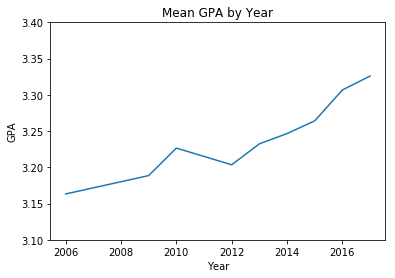

In [56]:
plt.plot(byTermYear.index, byTermYear['mean'])
plt.ylim(3.1,3.4)
plt.ylabel('GPA')
plt.xlabel('Year')
plt.title('Mean GPA by Year')
plt.show()

From the above graph, we can clearly see an upward trend in terms of the total mean GPA received over the year. This seems to indicate a strong case for GPA inflation.

In [57]:
byTermQtr = lgdata.groupby('term_quarter')[gradecols].sum().apply(summstats, axis = 1)
byTermQtr

,count,mean,std,min,25%,50%,75%,max
term_quarter,,,,,,,,
FA,763513.0,3.241651,0.830726,0.0,3.0,3.3,4.0,4.0
SP,575498.0,3.262474,0.838594,0.0,3.0,3.7,4.0,4.0
SU,121031.0,3.313068,0.876166,0.0,3.0,3.7,4.0,4.0
WI,556706.0,3.258460,0.823600,0.0,3.0,3.3,4.0,4.0


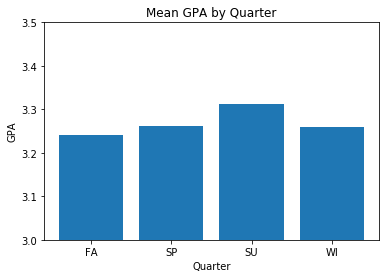

In [58]:
plt.bar(byTermQtr.index, byTermQtr['mean'])
plt.ylim(3,3.5)
plt.ylabel('GPA')
plt.xlabel('Quarter')
plt.title('Mean GPA by Quarter')
plt.show()

From the histogram above, we can also see that classes taught in the summer tend to give out higher grades

In [59]:
byTerm = lgdata.groupby(['term_year','term_quarter'])[gradecols].sum().apply(summstats, axis = 1).reset_index()
byTerm.head()

,term_year,term_quarter,count,mean,std,min,25%,50%,75%,max
0,2006,FA,85386.0,3.156105,0.826935,0.0,2.7,3.3,4.0,4.0
1,2006,SP,70874.0,3.171839,0.856930,0.0,2.7,3.3,4.0,4.0
2,2009,FA,91144.0,3.188597,0.842559,0.0,2.7,3.3,4.0,4.0
3,2010,SP,77820.0,3.227813,0.845715,0.0,3.0,3.3,4.0,4.0
4,2010,WI,86517.0,3.225381,0.820607,0.0,3.0,3.3,4.0,4.0


### Group by Professor

In [60]:
byProf = lgdata.groupby('prof_name')[gradecols].sum().apply(summstats, axis = 1)

In [61]:
byProf[byProf['count'] > 500].sort_values('mean',ascending = False).head()

,count,mean,std,min,25%,50%,75%,max
prof_name,,,,,,,,
i-nyoman-wenten,851.0,3.999295,0.014535,3.7,4.0,4.0,4.0,4.0
donald-neuen,1266.0,3.987046,0.114649,1.7,4.0,4.0,4.0,4.0
john-b-ullmen,541.0,3.986876,0.097343,3.0,4.0,4.0,4.0,4.0
chuc-v-bui,553.0,3.986618,0.069691,3.3,4.0,4.0,4.0,4.0
abhiman-kaushal,1595.0,3.982194,0.151269,0.0,4.0,4.0,4.0,4.0


We have found a professor who gives almost all A/A+ for his ETHNOMU 161B class

In [62]:
lgdata.loc[lgdata['prof_name'] == 'i-nyoman-wenten', gradecols + ['prof_name','course_name']].head()

,grade_F,grade_Dm,grade_D,grade_Dp,grade_Cm,grade_C,grade_Cp,grade_Bm,grade_B,grade_Bp,grade_Am,grade_A,grade_Ap,prof_name,course_name
3041,0,0,0,0,0,0,0,0,0,0,0,25,2,i-nyoman-wenten,ETHNOMU 161B
4379,0,0,0,0,0,0,0,0,0,0,0,50,1,i-nyoman-wenten,ETHNOMU 161B
5771,0,0,0,0,0,0,0,0,0,0,0,45,2,i-nyoman-wenten,ETHNOMU 161B
7717,0,0,0,0,0,0,0,0,0,0,0,36,3,i-nyoman-wenten,ETHNOMU 161B
9630,0,0,0,0,0,0,0,0,0,0,0,37,1,i-nyoman-wenten,ETHNOMU 161B


In [63]:
byProf[byProf['count'] > 500].sort_values('mean',ascending = True).head()

,count,mean,std,min,25%,50%,75%,max
prof_name,,,,,,,,
gail-e-kennedy,998.0,2.359519,1.229683,0.0,1.7,2.3,3.3,4.0
ngee-low,567.0,2.541623,1.224743,0.0,2.0,2.3,4.0,4.0
demetri-brizolis,969.0,2.558101,1.085431,0.0,2.0,2.7,3.3,4.0
huan-z-huang,1399.0,2.562330,1.090683,0.0,2.0,2.7,3.3,4.0
david-ravetch,4434.0,2.582567,1.093786,0.0,2.0,3.0,3.3,4.0


On the flipside, we see David Ravetch at the bottom, who is a Management Professor notorious for having really tough classes

### Group by Course

In [64]:
byCourse = lgdata.groupby('course_name')[gradecols].sum().apply(summstats, axis = 1)

In [65]:
byCourse[byCourse['count'] > 500].sort_values('mean', ascending = False).head()

,count,mean,std,min,25%,50%,75%,max
course_name,,,,,,,,
ETHNOMU 161B,643.0,3.999067,0.016718,3.7,4.0,4.0,4.0,4.0
LIFESCI 192B,609.0,3.997537,0.027093,3.7,4.0,4.0,4.0,4.0
MUSIC 90F,667.0,3.990255,0.161574,0.0,4.0,4.0,4.0,4.0
SOC WLF 195,593.0,3.988364,0.074090,3.0,4.0,4.0,4.0,4.0
ETHNOMU 161F,828.0,3.983937,0.094698,3.0,4.0,4.0,4.0,4.0


Again we notice that ETHNOMU 161B comes up, but we also see LIFESCI 192B

### Group by Department

In [66]:
byDept = lgdata.groupby('dept_name')[gradecols].sum().apply(summstats, axis = 1)
byDept[byDept['count'] > 500].sort_values('mean', ascending = False).head()

,count,mean,std,min,25%,50%,75%,max
dept_name,,,,,,,,
Armenian,1354.0,3.901551,0.273958,0.0,4.0,4.0,4.0,4.0
Vietnamese,1277.0,3.847142,0.417770,0.0,4.0,4.0,4.0,4.0
Military Science,1370.0,3.843431,0.386785,0.0,4.0,4.0,4.0,4.0
Iranian,2471.0,3.836787,0.391502,0.0,3.7,4.0,4.0,4.0
Hindi-Urdu,1701.0,3.829571,0.418501,0.0,3.7,4.0,4.0,4.0


Here, we see that certain departments like Armenian, Vietnamese and Military Sciences give an overwhelming amount of A/A+

### Group by Division

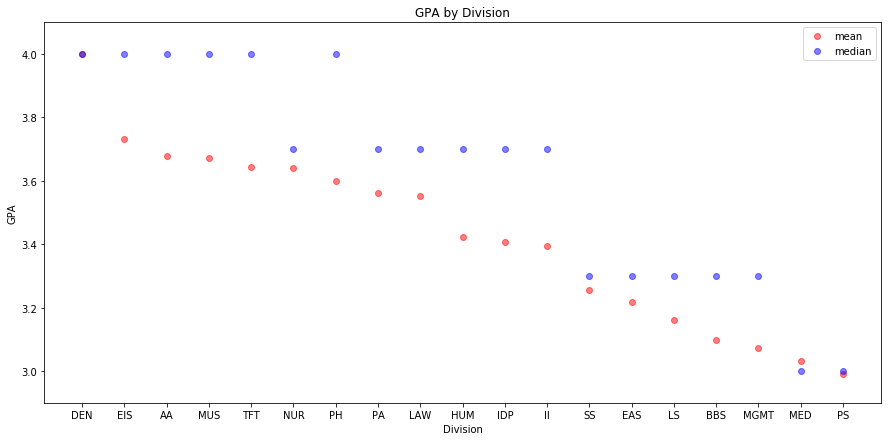

In [67]:
byDivision = lgdata.groupby('division')[gradecols].sum().apply(summstats, axis = 1)
gpa_by_division = byDivision.sort_values('mean', ascending = False)
plt.figure(figsize=(15,7))
plt.plot(gpa_by_division.index, gpa_by_division['mean'], 'ro', label = "mean", alpha = .5)
plt.plot(gpa_by_division.index,gpa_by_division['50%'], 'bo', label = "median", alpha = .5)
plt.legend()
plt.ylim(2.9,4.1)
plt.title("GPA by Division")
plt.ylabel("GPA")
plt.xlabel("Division")
plt.show()

Dentistry should be taken as an outlier since there are only 15 of such course instances taken and GPA is 4.0

The divisions at the top of the GPA spread are:
- Education and Information Systems
- School of Arts and Architecture
- School of Music
- School of Theater, Film and Television

Meanwhile, the majors at the bottom of the spread with medians of 3.0 are:
- Physical Sciences
- Medicine

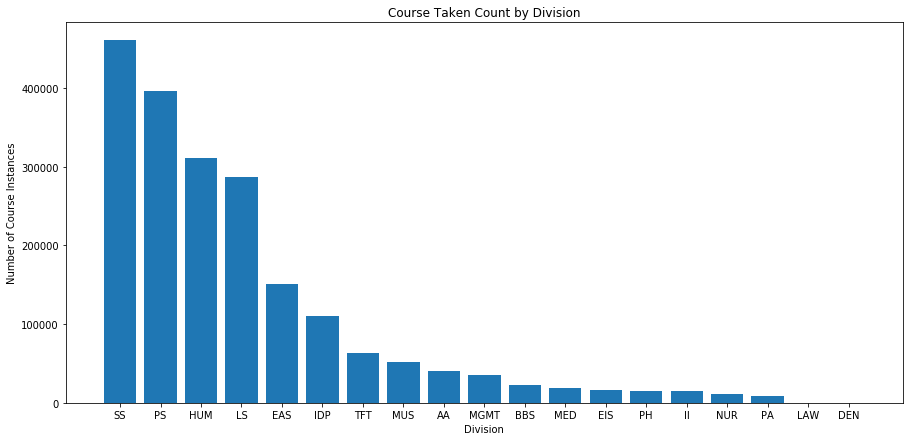

In [68]:
gpa_by_division = byDivision.sort_values('count', ascending = False)
plt.figure(figsize=(15,7))
plt.bar(gpa_by_division.index, gpa_by_division['count'])
plt.title("Course Taken Count by Division")
plt.ylabel("Number of Course Instances")
plt.xlabel("Division")
plt.show()

We also see from here that the most popular classes are from:
- Social Sciences
- Physical Sciences
- Humanities
- Life Sciences

This is to be expected because these form the bulk of the classes in the College of Letters and Science

Meanwhile, the least popular classes are from:
- School of Law
- School of Dentistry
- School of Public Affairs
- School of Nursing

## General Education Analysis

### Percentage A grade Variable

The most important concern for students is whether a GE will "hurt" one's GPA, thus percentage of A/A+ will be a good gauge of whether a course is actually "easy" or otherwise. We will call this variable '**gpa_4_pct**' because it is the percentage of students who scored 4.0 gpa for that course.

In [69]:
data['gpa_4_pct'] = data['grade_A_pct'] + data['grade_Ap_pct']
data.head()

,department,grade_A,grade_Am,grade_Ap,grade_B,grade_Bm,grade_Bp,grade_C,grade_Cm,grade_Cp,...,grade_pass_pct,grade_satisfactory_pct,grade_unsatisfactory_pct,dept_name,dept_short_name,course_name,prof_name,term,division,gpa_4_pct
0,30,4,8,2,6,5,15,3,4,7,...,0.089552,0.0,0.0,Atmospheric and Oceanic Sciences,A&O SCI,A&O SCI 1,kuo-nan-liou,2006-SP,PS,0.089552
1,30,45,6,9,49,11,14,24,2,6,...,0.162679,0.0,0.0,Atmospheric and Oceanic Sciences,A&O SCI,A&O SCI 2,richard-turco,2006-SP,PS,0.258373
2,30,72,9,1,39,6,19,19,5,8,...,0.048077,0.0,0.0,Atmospheric and Oceanic Sciences,A&O SCI,A&O SCI 3,jeffrey-lew,2006-SP,PS,0.350962
3,30,0,0,0,0,0,0,0,0,0,...,0.928571,0.0,0.0,Atmospheric and Oceanic Sciences,A&O SCI,A&O SCI 19,jeffrey-lew,2006-SP,PS,0.000000
4,30,12,14,0,8,10,9,0,2,8,...,0.000000,0.0,0.0,Atmospheric and Oceanic Sciences,A&O SCI,A&O SCI 102,j-david-neelin,2006-SP,PS,0.190476


### Merging GE information

We need to merge GE information from *ge* into *data*

In [70]:
ge["course_name"] = ge.apply(lambda x: x["Subject"] + " " + x["CatalogNo"],axis=1)
ge.loc[0::100,['Subject','CatalogNo','course_name']]

,Subject,CatalogNo,course_name
0,A&O SCI,1,A&O SCI 1
100,EPS SCI,13,EPS SCI 13
200,ITALIAN,46,ITALIAN 46
300,STATS,12,STATS 12


In [71]:
ge['foundation'] = ge["GE"].apply(lambda x: x.split("-")[0])
ge['category'] = ge["GE"].apply(lambda x: x.split("-")[1])
ge.loc[:,['GE','foundation','category']].head()

,GE,foundation,category
0,Scientific Inquiry-Physical Sciences,Scientific Inquiry,Physical Sciences
1,Scientific Inquiry-Physical Sciences,Scientific Inquiry,Physical Sciences
2,Scientific Inquiry-Physical Sciences,Scientific Inquiry,Physical Sciences
3,Society and Culture-Historical Analysis,Society and Culture,Historical Analysis
4,Society and Culture-Historical Analysis,Society and Culture,Historical Analysis


In [72]:
ge.GE.unique()
gedict = dict(zip(ge.GE.unique(),['SI-PS','SC-HA','SI-LS','SC-SA','AH-PLA','AH-VPA','AH-LCA']))
ge['requirement'] = [gedict[x] for x in ge.GE]
ge.head()

,Subject,CatalogNo,Name,GE,MedianA,TotClasses,ClassSize,course_name,foundation,category,requirement
0,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150,A&O SCI 1,Scientific Inquiry,Physical Sciences,SI-PS
1,A&O SCI,2,AIR POLLUTION,Scientific Inquiry-Physical Sciences,0.32,11,169,A&O SCI 2,Scientific Inquiry,Physical Sciences,SI-PS
2,A&O SCI,3,INTR-ATMOS ENVIRMNT,Scientific Inquiry-Physical Sciences,0.30,6,65,A&O SCI 3,Scientific Inquiry,Physical Sciences,SI-PS
3,AF AMER,6,BLACK INTLCTL THGHT,Society and Culture-Historical Analysis,0.57,2,42,AF AMER 6,Society and Culture,Historical Analysis,SC-HA
4,AFRO-AM,6,BLACK INTLCTL THGHT,Society and Culture-Historical Analysis,0.47,3,55,AFRO-AM 6,Society and Culture,Historical Analysis,SC-HA


In [73]:
data_ge = data.merge(ge, on = 'course_name')
data_ge.loc[0::500,['course_name','GE','foundation','category','requirement']].head()

,course_name,GE,foundation,category,requirement
0,A&O SCI 1,Scientific Inquiry-Physical Sciences,Scientific Inquiry,Physical Sciences,SI-PS
500,FILM TV 106A,Arts and Humanities-Visual and Performance Art...,Arts and Humanities,Visual and Performance Arts Analysis and Practice,AH-VPA
1000,PHYSICS 10,Scientific Inquiry-Physical Sciences,Scientific Inquiry,Physical Sciences,SI-PS
1500,STATS 10,Scientific Inquiry-Life Sciences,Scientific Inquiry,Life Sciences,SI-LS
2000,GEOG 1,Scientific Inquiry-Physical Sciences,Scientific Inquiry,Physical Sciences,SI-PS


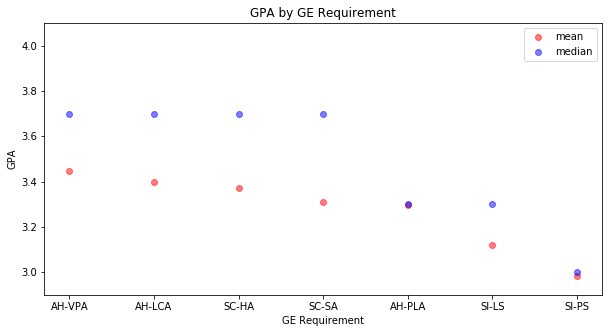

In [74]:
gpa_by_GE = data_ge.groupby('requirement')[gradecols].sum().apply(summstats, axis = 1).sort_values('mean', ascending = False)
plt.figure(figsize=(10,5))
plt.plot(gpa_by_GE.index, gpa_by_GE['mean'], 'ro', label = "mean", alpha = .5)
plt.plot(gpa_by_GE.index,gpa_by_GE['50%'], 'bo', label = "median", alpha = .5)
plt.legend()
plt.ylim(2.9,4.1)
plt.title("GPA by GE Requirement")
plt.ylabel("GPA")
plt.xlabel("GE Requirement")
plt.show()

From the above plot, we can see several things:
- Foundations of Scientific Inquiry has the lowest GPAs out of all the foundations
- Physical Sciences is the toughest GE category with the lowest mean and median GPA
- Visual Performing Arts Analysis and Practice is the easiest GE category with the highest mean and median GPA
- Mean of Physical Science GEs is a full grade lower than the mean of Visual Performing Arts GEs

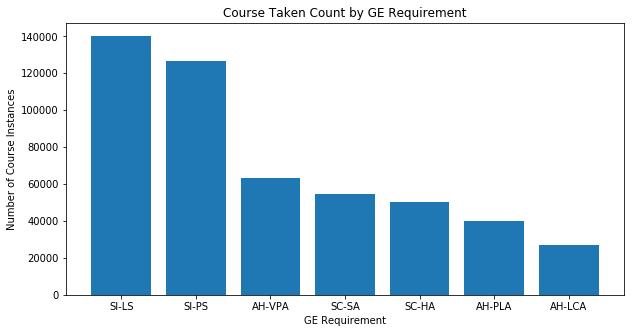

In [75]:
gpa_by_GE = data_ge.groupby('requirement')[gradecols].sum().apply(summstats, axis = 1).sort_values('count', ascending = False)
plt.figure(figsize=(10,5))
plt.bar(gpa_by_GE.index, gpa_by_GE['count'])
plt.title("Course Taken Count by GE Requirement")
plt.ylabel("Number of Course Instances")
plt.xlabel("GE Requirement")
plt.show()

In [126]:
data_ge

,department,grade_A,grade_Am,grade_Ap,grade_B,grade_Bm,grade_Bp,grade_C,grade_Cm,grade_Cp,...,Subject,CatalogNo,Name,GE,MedianA,TotClasses,ClassSize,foundation,category,requirement
0,30,4,8,2,6,5,15,3,4,7,...,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150,Scientific Inquiry,Physical Sciences,SI-PS
1,30,25,39,4,19,16,40,4,3,7,...,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150,Scientific Inquiry,Physical Sciences,SI-PS
2,30,21,23,1,24,13,28,11,4,10,...,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150,Scientific Inquiry,Physical Sciences,SI-PS
3,30,12,19,2,13,7,14,0,0,2,...,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150,Scientific Inquiry,Physical Sciences,SI-PS
4,30,39,40,0,14,9,32,4,2,5,...,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150,Scientific Inquiry,Physical Sciences,SI-PS
5,30,17,32,9,21,14,25,9,11,11,...,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150,Scientific Inquiry,Physical Sciences,SI-PS
6,30,28,7,7,13,17,19,9,5,11,...,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150,Scientific Inquiry,Physical Sciences,SI-PS
7,30,17,33,4,20,19,27,3,4,3,...,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150,Scientific Inquiry,Physical Sciences,SI-PS
8,30,25,44,5,17,5,25,1,2,0,...,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150,Scientific Inquiry,Physical Sciences,SI-PS
9,30,53,46,2,8,7,12,0,1,1,...,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150,Scientific Inquiry,Physical Sciences,SI-PS


We notice that interestingly, it is the Foundations of Scientific Inquiry GEs that have the most number of course spots taken

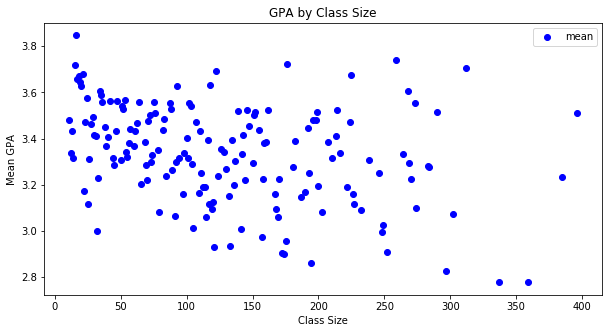

In [127]:
gpa_by_size = data_ge.groupby('ClassSize')[gradecols].sum().apply(summstats, axis = 1).sort_values('mean', ascending = False)
plt.figure(figsize=(10,5))
plt.plot(gpa_by_size.index, gpa_by_size['mean'], 'bo', label = "mean")
plt.legend()
plt.title("GPA by Class Size")
plt.ylabel("Mean GPA")
plt.xlabel("Class Size")
plt.show()

Unfortunately, there does not seem to be any correlation between Mean GPA and Class Size of courses

### Professor and Course Mean

We want to create a 2 new variables that will help indicate "easiness" of professors and courses:
- **prof_mean**: Mean GPA of the professor
- **course_mean**: Mean GPA of the course
- '**prof_freq**': Number of times the professor has taught courses (including non-GE ones)

In [132]:
byProf = lgdata.groupby('prof_name')[gradecols].sum().apply(summstats, axis = 1)
byProf.head()

,count,mean,std,min,25%,50%,75%,max
prof_name,,,,,,,,
a-a-gooch,39.0,3.341026,0.997818,0.0,3.0,3.7,4.00,4.0
a-a-schnurr,70.0,3.230000,0.872170,0.0,3.0,3.3,4.00,4.0
a-b-kaplan,48.0,3.979167,0.144338,3.0,4.0,4.0,4.00,4.0
a-b-mathur,59.0,2.798305,1.017179,0.0,2.0,3.0,3.85,4.0
a-b-saposnik,212.0,3.629717,0.486026,0.0,3.3,3.7,4.00,4.0


In [78]:
profs = byProf.loc[:,'count':'std'].reset_index()
profs.columns = ["prof_name","prof_count","prof_mean","prof_std"]
profs.head()

,prof_name,prof_count,prof_mean,prof_std
0,a-a-gooch,39.0,3.341026,0.997818
1,a-a-schnurr,70.0,3.230000,0.872170
2,a-b-kaplan,48.0,3.979167,0.144338
3,a-b-mathur,59.0,2.798305,1.017179
4,a-b-saposnik,212.0,3.629717,0.486026


In [79]:
byCourse = lgdata.groupby('course_name')[gradecols].sum().apply(summstats, axis = 1)
byCourse.head()

,count,mean,std,min,25%,50%,75%,max
course_name,,,,,,,,
A&O SCI 1,2670.0,3.228427,0.780949,0.0,3.0,3.3,3.7,4.0
A&O SCI 101,217.0,3.097235,0.817172,0.0,2.7,3.0,3.7,4.0
A&O SCI 102,608.0,3.293586,0.697920,0.0,3.0,3.3,4.0,4.0
A&O SCI 103,528.0,2.956818,0.824731,0.0,2.7,3.0,3.7,4.0
A&O SCI 104,685.0,2.941168,0.887502,0.0,2.3,3.0,3.7,4.0


In [80]:
courses = byCourse.loc[:,'count':'std'].reset_index()
courses.columns = ["course_name","course_count","course_mean","course_std"]
courses.head()

,course_name,course_count,course_mean,course_std
0,A&O SCI 1,2670.0,3.228427,0.780949
1,A&O SCI 101,217.0,3.097235,0.817172
2,A&O SCI 102,608.0,3.293586,0.697920
3,A&O SCI 103,528.0,2.956818,0.824731
4,A&O SCI 104,685.0,2.941168,0.887502


In [149]:
profcount = data.groupby('prof_name')['dept_name'].count().reset_index()
profcount.columns = ['prof_name', 'prof_freq']
profcount.head()

,prof_name,prof_freq
0,a-a-gooch,1
1,a-a-schnurr,4
2,a-b-kaplan,1
3,a-b-mathur,1
4,a-b-saposnik,5


In [147]:
data_ge_profcourse = data_ge.merge(profs, on = "prof_name").merge(courses, on = "course_name").merge(profcount, on = "prof_name")
data_ge_profcourse.head()

,department,grade_A,grade_Am,grade_Ap,grade_B,grade_Bm,grade_Bp,grade_C,grade_Cm,grade_Cp,...,foundation,category,requirement,prof_count,prof_mean,prof_std,course_count,course_mean,course_std,prof_freq
0,30,4,8,2,6,5,15,3,4,7,...,Scientific Inquiry,Physical Sciences,SI-PS,88.0,3.021591,0.970774,2670.0,3.228427,0.780949,3
1,30,25,39,4,19,16,40,4,3,7,...,Scientific Inquiry,Physical Sciences,SI-PS,430.0,3.369302,0.670968,2670.0,3.228427,0.780949,4
2,30,22,36,2,17,15,36,7,3,9,...,Scientific Inquiry,Physical Sciences,SI-PS,430.0,3.369302,0.670968,2670.0,3.228427,0.780949,4
3,30,21,23,1,24,13,28,11,4,10,...,Scientific Inquiry,Physical Sciences,SI-PS,744.0,3.253629,0.760260,2670.0,3.228427,0.780949,9
4,30,12,19,2,13,7,14,0,0,2,...,Scientific Inquiry,Physical Sciences,SI-PS,536.0,3.484515,0.592163,2670.0,3.228427,0.780949,8


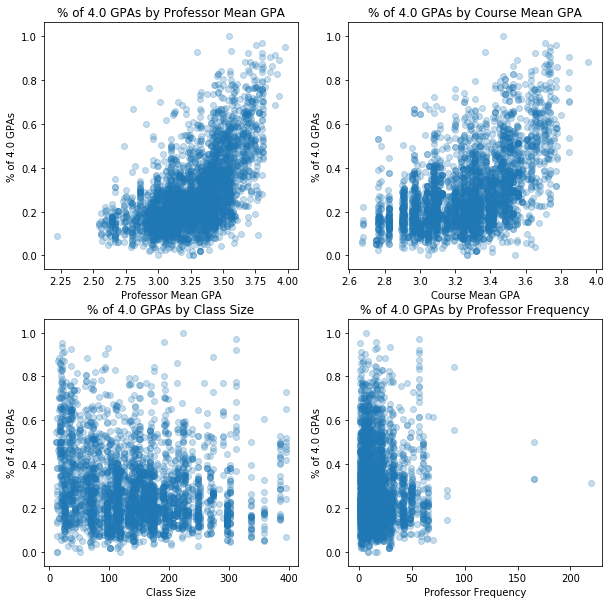

In [150]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(data_ge_profcourse['prof_mean'],data_ge_profcourse['gpa_4_pct'], alpha = .25)
plt.title("% of 4.0 GPAs by Professor Mean GPA")
plt.ylabel("% of 4.0 GPAs")
plt.xlabel("Professor Mean GPA")

plt.subplot(2,2,2)
plt.scatter(data_ge_profcourse['course_mean'],data_ge_profcourse['gpa_4_pct'], alpha = .25)
plt.title("% of 4.0 GPAs by Course Mean GPA")
plt.ylabel("% of 4.0 GPAs")
plt.xlabel("Course Mean GPA")

plt.subplot(2,2,3)
plt.scatter(data_ge_profcourse['ClassSize'],data_ge_profcourse['gpa_4_pct'], alpha = .25)
plt.title("% of 4.0 GPAs by Class Size")
plt.ylabel("% of 4.0 GPAs")
plt.xlabel("Class Size")

plt.subplot(2,2,4)
plt.scatter(data_ge_profcourse['prof_freq'],data_ge_profcourse['gpa_4_pct'], alpha = .25)
plt.title("% of 4.0 GPAs by Professor Frequency")
plt.ylabel("% of 4.0 GPAs")
plt.xlabel("Professor Frequency")

plt.show()

In [151]:
print(np.corrcoef(data_ge_profcourse['gpa_4_pct'], data_ge_profcourse['prof_mean'])[0,1])
print(np.corrcoef(data_ge_profcourse['gpa_4_pct'], data_ge_profcourse['course_mean'])[0,1])
print(np.corrcoef(data_ge_profcourse['gpa_4_pct'], data_ge_profcourse['ClassSize'])[0,1])
print(np.corrcoef(data_ge_profcourse['gpa_4_pct'], data_ge_profcourse['prof_freq'])[0,1])

0.5832295935290691
0.5186555223412526
-0.19791320952020502
-0.011220559965208267


While both graphs show a positive correlation, we notice that the correlation is stronger for the professor mean GPA than the course mean GPA. Hence, this suggests that the effect of professor leniency could be stronger than the effect of course difficulty when it comes to grades.

Although mean GPA seems mostly uncorrelated with Class Size and Professor Frequency, the negative correlation coefficient suggests that if there is any effect, it would probably be that smaller class sizes and newer professors lead to slightly better grades.

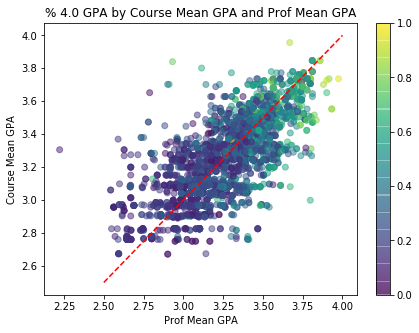

In [84]:
plt.figure(figsize=(7,5))
plt.scatter(data_ge_profcourse['prof_mean'],data_ge_profcourse['course_mean'], c = data_ge_profcourse['gpa_4_pct'], cmap = 'viridis', alpha = .5)
plt.title('% 4.0 GPA by Course Mean GPA and Prof Mean GPA')
plt.ylabel('Course Mean GPA')
plt.xlabel('Prof Mean GPA')
plt.xlim()
plt.plot([2.5,4], [2.5, 4], color='r', linestyle='--')
plt.colorbar()
plt.show()

We can see that if we use both Course Mean GPA and Prof Mean GPA, we could get better results for predicted the % of As for a particular course

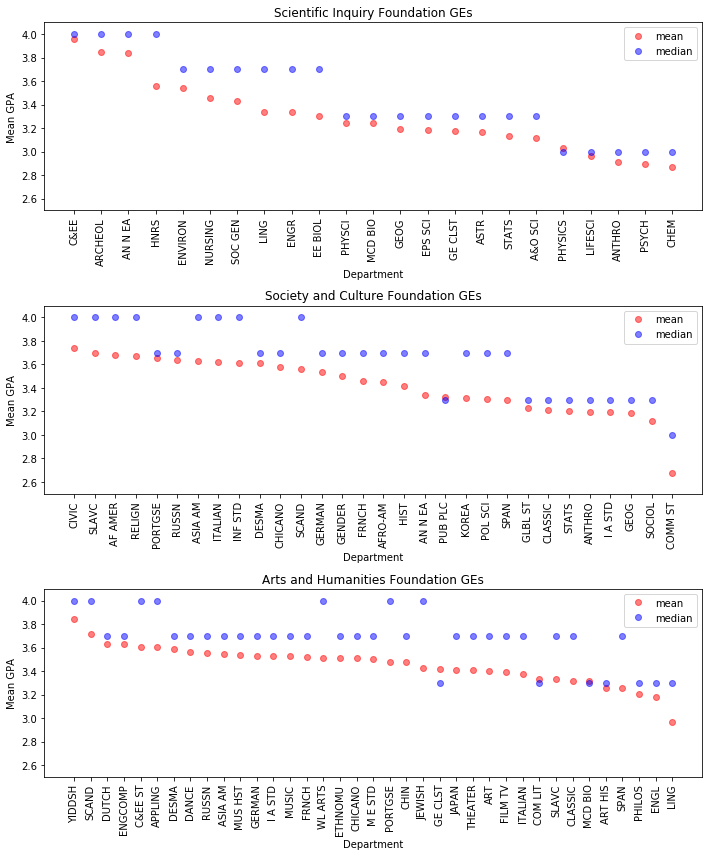

In [109]:
plt.figure(figsize = (10,12))
plt.subplot(3,1,1)
si_ge = data_ge_profcourse.loc[data_ge_profcourse.foundation == "Scientific Inquiry"]
siByDept = si_ge.groupby('dept_short_name')[gradecols].sum().apply(summstats, axis = 1).sort_values('mean', ascending = False)
plt.plot(siByDept.index, siByDept['mean'], 'ro', label = "mean", alpha = .5)
plt.plot(siByDept.index,siByDept['50%'], 'bo', label = "median", alpha = .5)
plt.legend()
plt.ylim(2.5,4.1)
plt.title("Scientific Inquiry Foundation GEs")
plt.ylabel("Mean GPA")
plt.xlabel("Department")
plt.xticks(rotation = 90)

plt.subplot(3,1,2)
sc_ge = data_ge_profcourse.loc[data_ge_profcourse.foundation == "Society and Culture"]
scByDept = sc_ge.groupby('dept_short_name')[gradecols].sum().apply(summstats, axis = 1).sort_values('mean', ascending = False)
plt.plot(scByDept.index, scByDept['mean'], 'ro', label = "mean", alpha = .5)
plt.plot(scByDept.index,scByDept['50%'], 'bo', label = "median", alpha = .5)
plt.legend()
plt.ylim(2.5,4.1)
plt.title("Society and Culture Foundation GEs")
plt.ylabel("Mean GPA")
plt.xlabel("Department")
plt.xticks(rotation = 90)

plt.subplot(3,1,3)
ah_ge = data_ge_profcourse.loc[data_ge_profcourse.foundation == "Arts and Humanities"]
ahByDept = ah_ge.groupby('dept_short_name')[gradecols].sum().apply(summstats, axis = 1).sort_values('mean', ascending = False)
plt.plot(ahByDept.index, ahByDept['mean'], 'ro', label = "mean", alpha = .5)
plt.plot(ahByDept.index,ahByDept['50%'], 'bo', label = "median", alpha = .5)
plt.legend()
plt.ylim(2.5,4.1)
plt.title("Arts and Humanities Foundation GEs")
plt.ylabel("Mean GPA")
plt.xlabel("Department")
plt.xticks(rotation = 90)

plt.tight_layout()
plt.show()

From the above plots, we can see that Mean GPAs varies by 3-4 whole grades across departments, which is a very big difference. The effect is the most pronounced for Scientific Inquiry Foundation GEs. For this reason, we will perform our machine learning algorithm on the Scientific Inquiry Foundation.

In [121]:
np.mean(si_ge['gpa_4_pct'] > 0.31)

0.2496551724137931

In [152]:
si_ge

,department,grade_A,grade_Am,grade_Ap,grade_B,grade_Bm,grade_Bp,grade_C,grade_Cm,grade_Cp,...,ClassSize,foundation,category,requirement,prof_count,prof_mean,prof_std,course_count,course_mean,course_std
0,30,4,8,2,6,5,15,3,4,7,...,150,Scientific Inquiry,Physical Sciences,SI-PS,88.0,3.021591,0.970774,2670.0,3.228427,0.780949
1,30,25,39,4,19,16,40,4,3,7,...,150,Scientific Inquiry,Physical Sciences,SI-PS,430.0,3.369302,0.670968,2670.0,3.228427,0.780949
2,30,22,36,2,17,15,36,7,3,9,...,150,Scientific Inquiry,Physical Sciences,SI-PS,430.0,3.369302,0.670968,2670.0,3.228427,0.780949
3,30,21,23,1,24,13,28,11,4,10,...,150,Scientific Inquiry,Physical Sciences,SI-PS,744.0,3.253629,0.760260,2670.0,3.228427,0.780949
4,30,12,19,2,13,7,14,0,0,2,...,150,Scientific Inquiry,Physical Sciences,SI-PS,536.0,3.484515,0.592163,2670.0,3.228427,0.780949
5,30,25,44,5,17,5,25,1,2,0,...,150,Scientific Inquiry,Physical Sciences,SI-PS,536.0,3.484515,0.592163,2670.0,3.228427,0.780949
6,30,53,46,2,8,7,12,0,1,1,...,150,Scientific Inquiry,Physical Sciences,SI-PS,536.0,3.484515,0.592163,2670.0,3.228427,0.780949
7,30,2,12,2,23,11,17,4,1,7,...,150,Scientific Inquiry,Physical Sciences,SI-PS,536.0,3.484515,0.592163,2670.0,3.228427,0.780949
8,30,39,40,0,14,9,32,4,2,5,...,150,Scientific Inquiry,Physical Sciences,SI-PS,326.0,3.255215,0.793795,2670.0,3.228427,0.780949
9,30,17,32,9,21,14,25,9,11,11,...,150,Scientific Inquiry,Physical Sciences,SI-PS,1196.0,3.236204,0.916105,2670.0,3.228427,0.780949


# Feature To Be Included (focus on Science GEs only)

Predict whether or not a GE is easy. Easy is defined as more than 50% A or A+ in a class 
Use logistic regression for this classification task. 

- '**prof_frequency**': Number of times a professor has taught courses at UCLA
- '**dept_name**': Department name
- '**course_mean**': Mean GPA of a course, indicates Course Difficulty
- '**prof_mean**': Mean GPA of a professor, indicates Professor Leniency
- '**term_quarter**': Quarter in which the course was taught
- '**ClassSize**': Class capacity of the course

In [192]:
data_ge_profcourse["is_easy"] = data_ge_profcourse.apply(lambda x: 1 if (x["grade_A_pct"] + x["grade_Ap_pct"])>=0.31 else 0, axis=1)
ge_subset = data_ge_profcourse[["prof_name","dept_name","course_mean","prof_mean",
                                "term_quarter","total_students","term","term_year","course_name",
                                "is_easy","prof_freq","ClassSize","foundation","category","requirement"]]
ge_subset[ge_subset["is_easy"]==1].shape[0]/ge_subset.shape[0]
ge_subset.head()

,prof_name,dept_name,course_mean,prof_mean,term_quarter,total_students,term,term_year,course_name,is_easy,prof_freq,ClassSize,foundation,category,requirement
0,kuo-nan-liou,Atmospheric and Oceanic Sciences,3.228427,3.021591,SP,67,2006-SP,2006,A&O SCI 1,0,3,150,Scientific Inquiry,Physical Sciences,SI-PS
1,alexander-hall,Atmospheric and Oceanic Sciences,3.228427,3.369302,FA,171,2006-FA,2006,A&O SCI 1,0,4,150,Scientific Inquiry,Physical Sciences,SI-PS
2,alexander-hall,Atmospheric and Oceanic Sciences,3.228427,3.369302,WI,177,2016-WI,2016,A&O SCI 1,0,4,150,Scientific Inquiry,Physical Sciences,SI-PS
3,j-david-neelin,Atmospheric and Oceanic Sciences,3.228427,3.253629,FA,154,2009-FA,2009,A&O SCI 1,0,9,150,Scientific Inquiry,Physical Sciences,SI-PS
4,carlos-mechoso,Atmospheric and Oceanic Sciences,3.228427,3.484515,WI,79,2010-WI,2010,A&O SCI 1,0,8,150,Scientific Inquiry,Physical Sciences,SI-PS


In [198]:
# focus on just one category of GE 
science_ge = ge_subset[ge_subset["foundation"]=="Scientific Inquiry"]
print(science_ge.dept_name.nunique())
print(science_ge.shape)

23
(1450, 15)


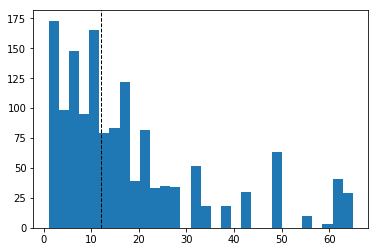

In [199]:
#ge_subset.prof_name.value_counts().values
plt.hist(science_ge.prof_freq.values, bins=30)[2]
plt.axvline(np.median(science_ge.prof_freq.values), color='k', linestyle='dashed', linewidth=1)

In [200]:
np.median(science_ge.prof_freq.values)

12.0

In [218]:
science_ge.reset_index(inplace=True)
del science_ge['index']
science_ge.head()

,prof_name,dept_name,course_mean,prof_mean,term_quarter,total_students,term,term_year,course_name,is_easy,prof_freq,ClassSize,foundation,category,requirement
0,kuo-nan-liou,Atmospheric and Oceanic Sciences,3.228427,3.021591,SP,67,2006-SP,2006,A&O SCI 1,0,3,150,Scientific Inquiry,Physical Sciences,SI-PS
1,alexander-hall,Atmospheric and Oceanic Sciences,3.228427,3.369302,FA,171,2006-FA,2006,A&O SCI 1,0,4,150,Scientific Inquiry,Physical Sciences,SI-PS
2,alexander-hall,Atmospheric and Oceanic Sciences,3.228427,3.369302,WI,177,2016-WI,2016,A&O SCI 1,0,4,150,Scientific Inquiry,Physical Sciences,SI-PS
3,j-david-neelin,Atmospheric and Oceanic Sciences,3.228427,3.253629,FA,154,2009-FA,2009,A&O SCI 1,0,9,150,Scientific Inquiry,Physical Sciences,SI-PS
4,carlos-mechoso,Atmospheric and Oceanic Sciences,3.228427,3.484515,WI,79,2010-WI,2010,A&O SCI 1,0,8,150,Scientific Inquiry,Physical Sciences,SI-PS


In [219]:
x_test_index = science_ge[(science_ge["term_year"] == 2017) |
                          (science_ge["term"]=="2016-SU") |
                          (science_ge["term"]=="2016-SP")].index.values
x_train_index = np.setdiff1d(science_ge.index.values, x_test_index)
print(len(x_test_index),len(x_train_index))

303 1147


We chose the most recent 20% of our data as the hold-out set, which we will use for testing our model

In [220]:
# one_hot encoding for dept_name, term_quarter, Category
# one hot encoding for categorical variables 
# do not include year-quarter as a feature
from sklearn import preprocessing

cat_variables = science_ge[["dept_name","term_quarter","category"]]
le = preprocessing.LabelEncoder()
X_2 = cat_variables.apply(le.fit_transform)
enc = preprocessing.OneHotEncoder()
enc.fit(X_2)
cat_variables_onehot = enc.transform(X_2).toarray()

# get the labels from one-hot-encoding

labels = {}
for i in range(len(cat_variables.columns)):
    for j in range(len(cat_variables[cat_variables.columns[i]].unique())):
        my_key = cat_variables.columns[i] + "*" + cat_variables[cat_variables.columns[i]].unique()[j]
        labels[my_key] = X_2[X_2.columns[i]].unique()[j]
        
# get the numeric variables and feature scale them 
numeric_variables = science_ge[["prof_freq","ClassSize","course_mean","prof_mean"]]
scaler = preprocessing.StandardScaler()
numeric_variables_scaled = scaler.fit_transform(numeric_variables)

# concatenate one hot encoding of categorical variables with the numeric variables
X = np.c_[numeric_variables_scaled, cat_variables_onehot]

# get the is_easy_class label
y = science_ge.is_easy.values

print(X.shape)

(1450, 33)


In [221]:
# 5-fold cross validation 
# hold out testing set to only contain data for the last quarter: 2017 spring 

X_test = X[x_test_index]
X_train = X[x_train_index]
print(X_test.shape)
print(X_train.shape)

(303, 33)
(1147, 33)


In [222]:
y_train = y[x_train_index]
y_test = y[x_test_index]
print(y_test.shape)
print(y_train.shape)

(303,)
(1147,)


In [263]:
303/1452 # 20.8% is testing data 

0.20867768595041322

Hence, we see that 20.8% of our data is used as test data.

## Grid Search + Modeling + Evaluation

We will use Randomized Search Cross Validation

In [223]:
# randomized search 5-fold cross validation 
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

from pprint import pprint
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [224]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=False, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)
rf_random.best_params_


C:\Users\kaize\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [225]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,10,20,30],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 5, 8, 10, 12],
    'n_estimators': [100, 200, 300, 500]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = False)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 200}

In [226]:
def find_best_threshold(model):
    best_threshold = 0.01
    best_f1 = 0
    threshold = 0.01
    while threshold < 0.5:
        y_train_prediction_prob = model.predict_proba(X_train)
        y_train_prediction = (y_train_prediction_prob [:,1] >= threshold).astype('int')
        f1 = f1_score(y_train,y_train_prediction)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
        threshold += 0.01
    return(best_f1,best_threshold)

In [227]:
rnd_clf = RandomForestClassifier(bootstrap=True,max_depth=5,max_features=2,min_samples_leaf=3,min_samples_split=5,n_estimators=100, n_jobs=-1, random_state=42)
model = rnd_clf.fit(X_train, y_train)
find_best_threshold(model)

(0.690566037735849, 0.26000000000000006)

In [228]:
#y_train_prediction = model.predict(X_train)
y_train_prediction_prob = model.predict_proba(X_train)
y_train_prediction = (y_train_prediction_prob [:,1] >= 0.25).astype('int')
print(confusion_matrix(y_train,y_train_prediction))
print(f1_score(y_train,y_train_prediction))

[[786 102]
 [ 69 190]]
0.6896551724137931


In [229]:
# predicting on hold out test data

y_test_prediction_prob = model.predict_proba(X_test)
y_test_prediction = (y_test_prediction_prob [:,1] >= 0.25).astype('int')
print(f1_score(y_test,y_test_prediction))
print(confusion_matrix(y_test,y_test_prediction))

0.5833333333333333
[[167  33]
 [ 47  56]]


In [231]:
 # find feature importance by grabbing the labels 
from tabulate import tabulate

labels_ordered = ["prof_frequency","ClassSize","course_mean","prof_mean"]
    # put the labels into data frame and then have a new column for the first part of label, do a group_by, then sort
    # then get the labels into an ordered list 
temporary = pd.Series(labels).to_frame().reset_index().rename(columns={'index': 'label', 0: 'label_order'})
temporary["original"]=temporary["label"].apply(lambda x: x.split("*")[0])
temporary = temporary.groupby("original",sort = False).apply(lambda x: x.sort_values(["label_order"])).reset_index(drop=True)

    # then append to labels_ordered 
for i in temporary.label.values:
    labels_ordered.append(i)

In [232]:
# print out the values 
values = sorted(zip(labels_ordered, model.feature_importances_), key=lambda x: x[1] * -1)
headers = ["feature", "significance_score"]
print(tabulate(values, headers, tablefmt="plain"))

feature                                                 significance_score
prof_mean                                                       0.248974
course_mean                                                     0.204955
ClassSize                                                       0.121581
prof_frequency                                                  0.0697769
dept_name*Linguistics                                           0.0380918
dept_name*Life Sciences                                         0.0341549
term_quarter*SU                                                 0.0341114
category*Physical Sciences                                      0.0286998
term_quarter*FA                                                 0.0267841
dept_name*Nursing                                               0.0267667
dept_name*Physiological Science                                 0.017251
category*Life Sciences                                          0.0169344
dept_name*Physics                        